In [1]:
import pandas as pd

# 데이터 세트 호출
m_df = pd.read_csv('./datasets/medical_insurance.csv', low_memory=False)
m_df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
2767,47,female,45.320,1,no,southeast,8569.86180
2768,21,female,34.600,0,no,southwest,2020.17700
2769,19,male,26.030,1,yes,northwest,16450.89470
2770,23,male,18.715,0,no,northwest,21595.38229


#### 📊 데이터 전처리

In [2]:
# 중복행 제거
pre_m_df = m_df.drop_duplicates().reset_index(drop=True)

In [3]:
# 타겟 데이터 이상치 제거
from sklearn.preprocessing import StandardScaler

# 표준화 객체 생성
std = StandardScaler()
# 데이터 표준화 변환
result = std.fit_transform(pre_m_df[['charges']])
# 표준화 데이터 프레임 생성
std_pre_m_df = pd.DataFrame(result, columns=['charges'])

# 타겟 데이터 이상치 제거
std_pre_m_df = std_pre_m_df[std_pre_m_df.charges.between(-1.96, 1.96)]

# 이상치 제거후 유지되는 인덱스를 대조하여 원본 데이터 이상치 제거
pre_m_df = pre_m_df.iloc[std_pre_m_df.index].reset_index(drop=True)

In [4]:
# 타겟 컬럼 분포 변환
from sklearn.preprocessing import PowerTransformer

ptf = PowerTransformer(standardize=False)
pre_m_df['charges'] = ptf.fit_transform(pre_m_df[['charges']])

In [5]:
from sklearn.preprocessing import LabelEncoder

# 데이터 프레임 복제
enc_m_df = pre_m_df.copy()
encoders = {}

# 문자열 컬럼 추출
columns = ['sex', 'smoker']

# 반복하여 컬럼 인코딩 처리:
for column in columns:
    # 레이블인코더 객체 생성
    encoder = LabelEncoder()
    # 문자열 데이터 정수로 형변환
    result = encoder.fit_transform(enc_m_df[column])
    # 형변환 값으로 대체
    enc_m_df[column] = result
    # 원본 데이터 담기
    encoders[column] = encoder.classes_

In [6]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder

# 원 핫 인코더 객체 생성
# sparse_output: False = 밀집행렬(실제 값으로 채워진 행렬) 반환
one_hot_encoder = OneHotEncoder(sparse_output=False)
# 지역 피처 인코딩 처리
result = one_hot_encoder.fit_transform(enc_m_df[['region']])

# 인코딩 값 데이터 프레임으로 생성하고 정수로 형변환한 뒤, 기존 데이터 프레임과 병합
enc_m_df = pd.concat([enc_m_df, pd.DataFrame(result, columns=one_hot_encoder.categories_).astype(np.int8)], axis=1)

# 사용이 끝난 데이터 제거
enc_m_df = enc_m_df.drop(labels='region', axis=1)

# 원 핫 인코딩 컬럼명 변경
enc_m_df.rename(columns={
    ('northeast',): 'northeast',
    ('northwest',): 'northwest',
    ('southeast',): 'southeast',
    ('southwest',): 'southwest',
}, inplace=True)

In [7]:
# 타겟 컬럼 위치 변경을 위해 새로운 컬럼에 데이터 담기
enc_m_df['target'] = enc_m_df.charges
# 기존 컬럼은 제거
enc_m_df = enc_m_df.drop(labels='charges', axis=1)

### 🌟 1Cycle

#### 🚩 1Cycle 결과
- 회귀  
**MSE: 2.0043, RMSE: 1.4158, MSLE: 0.0052, RMSLE: 0.0720, R2: 0.7340**

- 다중 회귀  
**MSE: 2.2306, RMSE: 1.4935, MSLE: 0.0060, RMSLE: 0.0774, R2: 0.7040**

- 회귀 모델(GradientBoostingRegressor)  
**MSE: 1.9586, RMSE: 1.3995, MSLE: 0.0053, RMSLE: 0.0727, R2: 0.7401**

#### 💡 분석
- 회귀 분석 결과 R2 점수가 약 0.76이 나옴에 따라 선형 패턴을 지니고 있다고 보여졌으나,  
  다중 회귀로 곡선을 부여하였을 때 약 R2 점수가 0.82로 상승함에 따라 완전한 선형은 아니고 비선형의 패턴도 띄고 있음을 확인함.
- 회귀 모델 중 GradientBoostingRegressor을 사용하였을 때, 가장 좋은 성능을 보임에 따라 해당 모델을 선택하는 것이 적합하다고 판단됨.

### 🌟 2Cycle

#### 📊 회귀

In [8]:
from statsmodels.api import OLS

# 데이터 세트 분리
# 피처, 타겟 데이터 분리
features, targets = enc_m_df.iloc[:, :-1], enc_m_df.iloc[:, -1]

# OLS 객체 생성
model = OLS(targets, features)
# 모델 훈련 및 정보 출력
print(model.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.697
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     349.9
Date:                Fri, 10 May 2024   Prob (F-statistic):          6.16e-309
Time:                        17:17:14   Log-Likelihood:                -2362.8
No. Observations:                1224   AIC:                             4744.
Df Residuals:                    1215   BIC:                             4790.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age            0.1286      0.003     37.434      0.0

In [9]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def get_vif(features):
    vif = pd.DataFrame()
    vif['vif_score'] = [variance_inflation_factor(features, i) for i in range(features.shape[1])]
    vif['features'] = features.columns
    return vif

In [10]:
# VIF 확인
get_vif(features)

,vif_score,features
0,1.025340,age
1,1.004046,sex
2,1.142205,bmi
3,1.003564,children
4,1.063161,smoker
5,9.350937,northeast
6,9.585279,northwest
7,11.636787,southeast
8,10.060127,southwest


In [11]:
# 상관관계 확인
enc_m_df.corr()['target'].sort_values(ascending=False)[1:]

smoker       0.546188
age          0.542972
children     0.151047
northeast    0.063126
northwest    0.015186
bmi         -0.017568
sex         -0.034228
southwest   -0.034363
southeast   -0.043222
Name: target, dtype: float64

<Axes: >

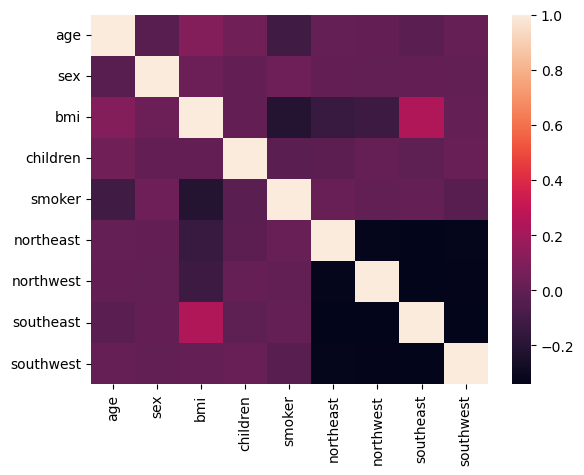

In [12]:
import seaborn as sns

# 상관관계 히트맵 확인
sns.heatmap(features.corr())

#### 🚩 결과
- 상관관계가 낮고 다중 공산성이 높은 피처 제거
- northeast, northwest, southeast, southwest, sex 제거

In [13]:
# 피처 제거
columns = ['northeast', 'northwest', 'southeast', 'southwest', 'sex']

enc_m_df = enc_m_df.drop(columns=columns, axis=1)
enc_m_df

,age,bmi,children,smoker,target
0,19,27.900,0,1,21.670016
1,18,33.770,1,0,13.555550
2,28,33.000,3,0,16.598254
3,33,22.705,0,0,22.797186
4,32,28.880,0,0,16.120202
...,...,...,...,...,...
1219,50,30.970,3,0,19.785499
1220,18,31.920,0,0,14.304192
1221,18,36.850,0,0,13.385460
1222,21,25.800,0,0,14.014294


In [14]:
from statsmodels.api import OLS

features, targets = enc_m_df.iloc[:, :-1], enc_m_df.iloc[:, -1]

model = OLS(targets, features)
print(model.fit().summary())

                                 OLS Regression Results                                
Dep. Variable:                 target   R-squared (uncentered):                   0.981
Model:                            OLS   Adj. R-squared (uncentered):              0.981
Method:                 Least Squares   F-statistic:                          1.581e+04
Date:                Fri, 10 May 2024   Prob (F-statistic):                        0.00
Time:                        17:17:15   Log-Likelihood:                         -2913.6
No. Observations:                1224   AIC:                                      5835.
Df Residuals:                    1220   BIC:                                      5856.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [15]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def get_vif(features):
    vif = pd.DataFrame()
    vif['vif_score'] = [variance_inflation_factor(features, i) for i in range(features.shape[1])]
    vif['features'] = features.columns
    return vif

In [16]:
get_vif(features)

,vif_score,features
0,7.385025,age
1,7.691248,bmi
2,1.762004,children
3,1.113228,smoker


In [17]:
enc_m_df.corr()['target'].sort_values(ascending=False)[1:]

smoker      0.546188
age         0.542972
children    0.151047
bmi        -0.017568
Name: target, dtype: float64

<Axes: >

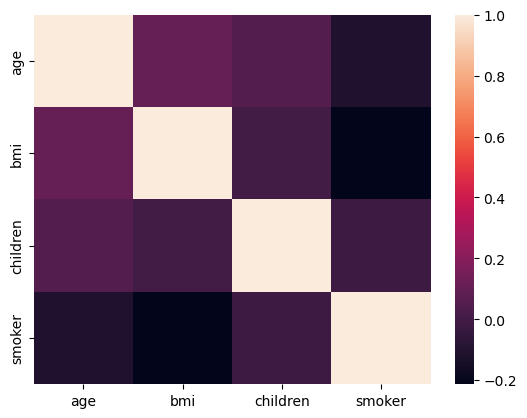

In [18]:
import seaborn as sns

# 상관관계 히트맵 확인
sns.heatmap(features.corr())

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

# 데이터 세트 분리
# 피처, 타겟 데이터 분리
features, targets = enc_m_df.iloc[:, :-1], enc_m_df.iloc[:, -1]

# 학습/테스트 및 문제/정답 데이터 세트 분리
X_train, X_test, y_train, y_test = \
train_test_split(features, targets, test_size=0.2, random_state=124)

# 가장 성능이 높았던 모델 가져오기
gb_r = GradientBoostingRegressor(random_state=124)

# 훈련
gb_r.fit(X_train, y_train)

GradientBoostingRegressor(random_state=124)

In [20]:
import numpy as np
from sklearn.metrics import mean_squared_log_error, mean_squared_error, r2_score

def get_evaluation(y_test, prediction):
    MSE = mean_squared_error(y_test, prediction)
    RMSE = np.sqrt(MSE)
    MSLE = mean_squared_log_error(y_test, prediction)
    RMSLE = np.sqrt(MSLE)
    R2 = r2_score(y_test, prediction)
    print('MSE: {:.4f}, RMSE: {:.4f}, MSLE: {:.4f}, RMSLE: {:.4f}, R2: {:.4f}'\
         .format(MSE, RMSE, MSLE, RMSLE, R2))

In [21]:
# 예측
prediction = gb_r.predict(X_test)
# 평가
get_evaluation(y_test, prediction)

MSE: 2.0182, RMSE: 1.4206, MSLE: 0.0054, RMSLE: 0.0733, R2: 0.7322


#### 📊 시각화

In [22]:
cycle2_data = {
    'model': ['회귀모델(gb_r)', '전처리 후 회귀모델(gb_r)'],
    'R2': [0.7401, 0.7322],
}

cycle2 = pd.DataFrame(cycle2_data)

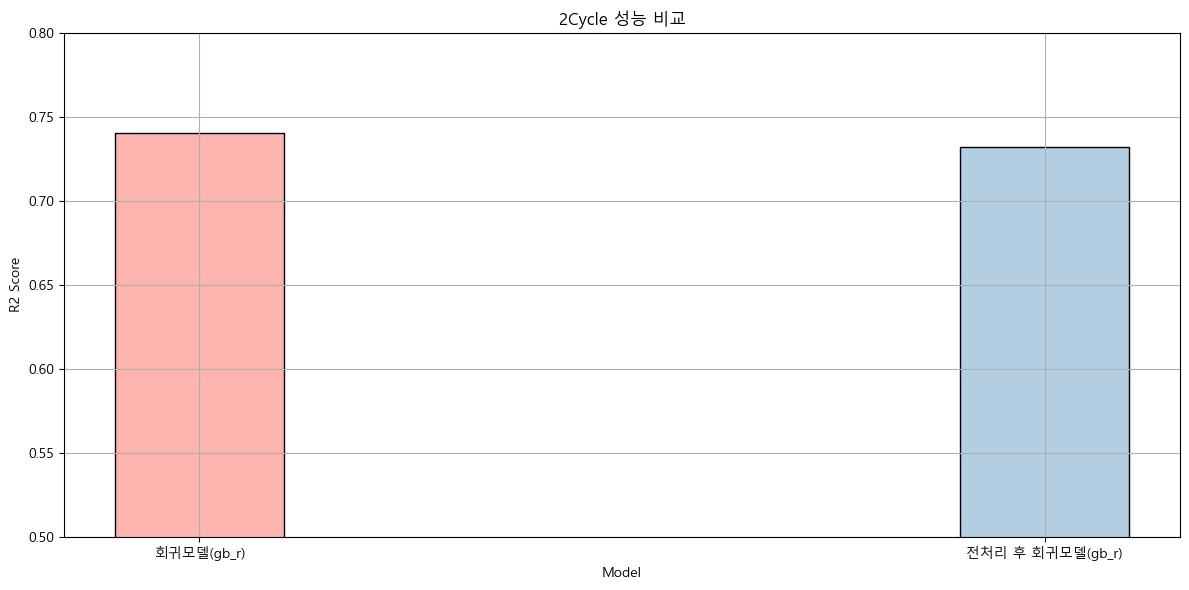

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# 한글 폰트 경로 설정
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

# 그래프 그리기
plt.figure(figsize=(12, 6))

# 컬러맵 가져오기
cmap = plt.get_cmap('Pastel1')

plt.bar(cycle2['model'], cycle2['R2'], color=cmap(np.array([0, 1, 2])), edgecolor='black', width=0.2)
plt.title('2Cycle 성능 비교')
plt.xlabel('Model')
plt.ylabel('R2 Score')
plt.grid(True)

# y축의 범위 지정
plt.ylim(0.5, 0.8)

plt.tight_layout()
plt.show()

#### 🚩 1Cycle 결과
- 회귀 모델(GradientBoostingRegressor)  
**MSE: 1.9586, RMSE: 1.3995, MSLE: 0.0053, RMSLE: 0.0727, R2: 0.7401**

#### 🚩 2Cycle 결과
- 전처리 후 회귀 모델(GradientBoostingRegressor)  
**MSE: 2.0182, RMSE: 1.4206, MSLE: 0.0054, RMSLE: 0.0733, R2: 0.7322**

#### 💡 분석
- 상관관계가 낮은 피처 제거 후 성능이 매우 근소한 차이로 저하된 것을 확인하였지만, 다중 공산성을 해결하기 위해 제거하기로 함.
- validation 분리 후 훈련하여 성능평가를 재진행하기로 함.